In [ ]:


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing import image
import numpy as np
from collections import defaultdict
import os
import shutil
import random
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.models import load_model



In [5]:
source_train_dir = './original_data/train'
source_test_dir = './original_data/test'
target_base = 'data'

split_ratios = [0.85, 0.15]

for subset in ['train', 'val', 'test']:
    subset_path = os.path.join(target_base, subset)
    if os.path.exists(subset_path):
        print(f"Removing old {subset} directory...")
        shutil.rmtree(subset_path)

for class_name in os.listdir(source_train_dir):
    class_path = os.path.join(source_train_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    files = [f for f in os.listdir(class_path) if not f.startswith('.')] 
    random.shuffle(files)

    total = len(files)
    train_end = int(split_ratios[0] * total)

    train_files = files[:train_end]
    val_files = files[train_end:]

    print(f"{class_name}: Total={total}, Train={len(train_files)}, Val={len(val_files)}")

    for split, split_files in zip(['train', 'val'], [train_files, val_files]):
        split_dir = os.path.join(target_base, split, class_name)
        os.makedirs(split_dir, exist_ok=True)
        for file in split_files:
            src = os.path.join(class_path, file)
            dst = os.path.join(split_dir, file)
            shutil.copy2(src, dst)

for class_name in os.listdir(source_test_dir):
    class_path = os.path.join(source_test_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    target_class_dir = os.path.join(target_base, 'test', class_name)
    os.makedirs(target_class_dir, exist_ok=True)

    test_files = [f for f in os.listdir(class_path) if not f.startswith('.')]
    print(f"{class_name} Test: {len(test_files)} images")

    for file in test_files:
        src = os.path.join(class_path, file)
        dst = os.path.join(target_class_dir, file)
        shutil.copy2(src, dst)


Removing old train directory...
Removing old val directory...
Removing old test directory...
Very Mild Impairment: Total=2560, Train=2176, Val=384
Mild Impairment: Total=2560, Train=2176, Val=384
No Impairment: Total=2560, Train=2176, Val=384
Moderate Impairment: Total=2560, Train=2176, Val=384
Very Mild Impairment Test: 448 images
Mild Impairment Test: 179 images
No Impairment Test: 640 images
Moderate Impairment Test: 12 images


Distribution of Images in Each Subset:
Mild Impairment: Train: 2176, Val: 384, Test: 179
Moderate Impairment: Train: 2176, Val: 384, Test: 12
No Impairment: Train: 2176, Val: 384, Test: 640
Very Mild Impairment: Train: 2176, Val: 384, Test: 448


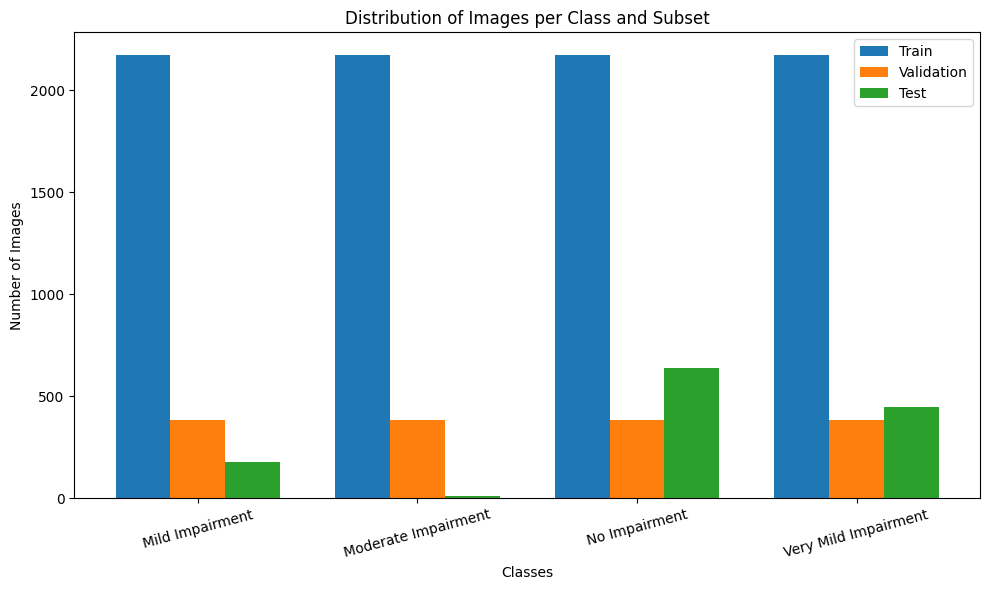

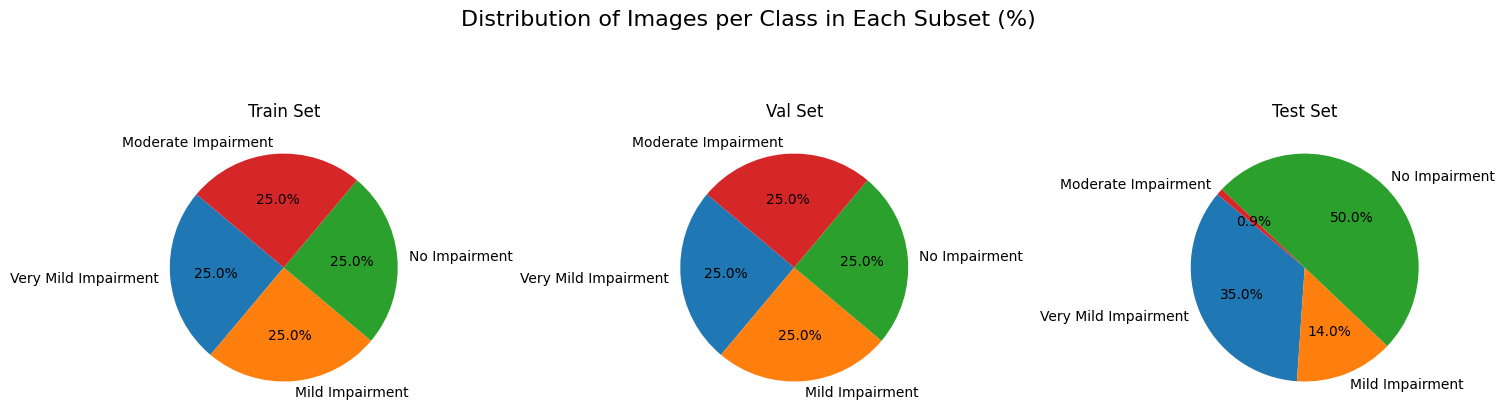

In [6]:
base_path = "./data" 

data_counts = {
    "train": defaultdict(int),
    "val": defaultdict(int),
    "test": defaultdict(int)
}

for subset in data_counts.keys():
    subset_path = os.path.join(base_path, subset)
    for label in os.listdir(subset_path):
        label_path = os.path.join(subset_path, label)
        count = len(os.listdir(label_path))
        data_counts[subset][label] = count

labels = sorted(list(data_counts["train"].keys()))
x = range(len(labels))
bar_width = 0.25

train_counts = [data_counts["train"][label] for label in labels]
val_counts = [data_counts["val"][label] for label in labels]
test_counts = [data_counts["test"][label] for label in labels]

print("Distribution of Images in Each Subset:")
for label in labels:
    print(f"{label}: Train: {data_counts['train'][label]}, Val: {data_counts['val'][label]}, Test: {data_counts['test'][label]}")

plt.figure(figsize=(10, 6))
plt.bar([i - bar_width for i in x], train_counts, width=bar_width, label='Train')
plt.bar(x, val_counts, width=bar_width, label='Validation')
plt.bar([i + bar_width for i in x], test_counts, width=bar_width, label='Test')

plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.title("Distribution of Images per Class and Subset")
plt.xticks(ticks=x, labels=labels, rotation=15)
plt.legend()
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, subset in enumerate(["train", "val", "test"]):
    counts = data_counts[subset]
    axes[i].pie(
        counts.values(),
        labels=counts.keys(),
        autopct='%1.1f%%',
        startangle=140
    )
    axes[i].set_title(f"{subset.capitalize()} Set")

plt.suptitle("Distribution of Images per Class in Each Subset (%)", fontsize=16)
plt.tight_layout()
plt.show()


Tamanhos de imagem (largura x altura):
(128, 128): 8704 imagens

Modos de cor encontrados:
L: 8704 imagens

Número de imagens por classe:
Mild Impairment: 2176
Moderate Impairment: 2176
No Impairment: 2176
Very Mild Impairment: 2176


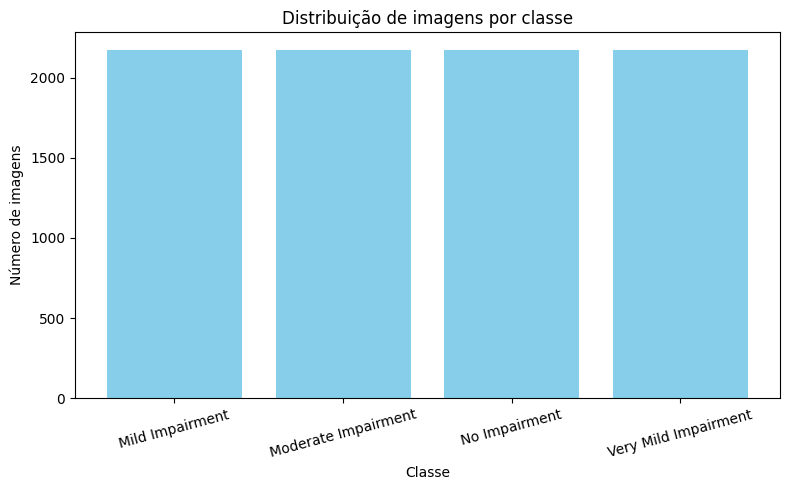

In [7]:

dataset_path = "./data/train"

image_shapes = defaultdict(int)
color_modes = defaultdict(int)
class_counts = {}

for cls in sorted(os.listdir(dataset_path)):
    class_path = os.path.join(dataset_path, cls)
    if not os.path.isdir(class_path):
        continue

    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    class_counts[cls] = len(images)

    for img_file in images:
        img_path = os.path.join(class_path, img_file)
        try:
            with Image.open(img_path) as img:
                image_shapes[img.size] += 1
                color_modes[img.mode] += 1
        except Exception as e:
            print(f"Erro ao abrir imagem: {img_path}\n{e}")

print("\nTamanhos de imagem (largura x altura):")
for shape, count in image_shapes.items():
    print(f"{shape}: {count} imagens")

print("\nModos de cor encontrados:")
for mode, count in color_modes.items():
    print(f"{mode}: {count} imagens")

print("\nNúmero de imagens por classe:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")

plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel("Classe")
plt.ylabel("Número de imagens")
plt.title("Distribuição de imagens por classe")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


In [8]:
train_dir = './data/train'
test_dir = './data/test'
val_dir = './data/val'

img_size = (128, 128)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical' 
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical' 
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical' 
)

class_names = test_ds.class_names 

normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 8704 files belonging to 4 classes.
Found 1536 files belonging to 4 classes.
Found 1279 files belonging to 4 classes.


In [11]:

base_model = VGG16(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
for layer in base_model.layers:
    layer.trainable = False

x = layers.Flatten()(base_model.output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(4, activation='softmax')(x) 


model = Model(inputs=base_model.input, outputs=x)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Treinar o modelo
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

NameError: name 'VGG16' is not defined

In [ ]:
for layer in base_model.layers[-4:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)


Epoch 1/5
272/272 ━━━━━━━━━━━━━━━━━━━━ 284s 1s/step - accuracy: 0.8575 - loss: 0.3421 - val_accuracy: 0.8789 - val_loss: 0.2829
Epoch 2/5
272/272 ━━━━━━━━━━━━━━━━━━━━ 282s 1s/step - accuracy: 0.9122 - loss: 0.2309 - val_accuracy: 0.8978 - val_loss: 0.2468
Epoch 3/5
272/272 ━━━━━━━━━━━━━━━━━━━━ 282s 1s/step - accuracy: 0.9432 - loss: 0.1633 - val_accuracy: 0.9316 - val_loss: 0.1859
Epoch 4/5
272/272 ━━━━━━━━━━━━━━━━━━━━ 283s 1s/step - accuracy: 0.9667 - loss: 0.1188 - val_accuracy: 0.9434 - val_loss: 0.1669
Epoch 5/5
272/272 ━━━━━━━━━━━━━━━━━━━━ 282s 1s/step - accuracy: 0.9713 - loss: 0.0969 - val_accuracy: 0.9557 - val_loss: 0.1405


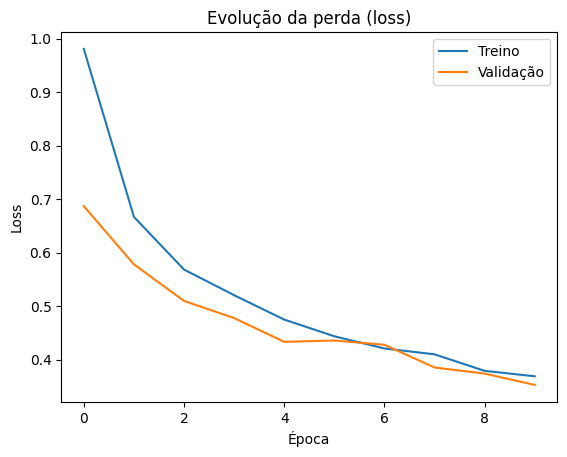

In [ ]:
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Evolução da perda (loss)')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

test_loss, test_accuracy = model.evaluate(val_ds)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

40/40 ━━━━━━━━━━━━━━━━━━━━ 28s 709ms/step - accuracy: 0.9120 - loss: 0.2495
Test accuracy: 90.85%
48/48 ━━━━━━━━━━━━━━━━━━━━ 33s 679ms/step - accuracy: 0.9566 - loss: 0.1337
Test accuracy: 95.57%


In [ ]:
history_more_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    initial_epoch=15,   
    epochs=30           
)




Epoch 16/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 276s 1s/step - accuracy: 0.9811 - loss: 0.0700 - val_accuracy: 0.9362 - val_loss: 0.1634
Epoch 17/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 275s 1s/step - accuracy: 0.9843 - loss: 0.0613 - val_accuracy: 0.9655 - val_loss: 0.1108
Epoch 18/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 276s 1s/step - accuracy: 0.9846 - loss: 0.0544 - val_accuracy: 0.9714 - val_loss: 0.0911
Epoch 19/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 275s 1s/step - accuracy: 0.9973 - loss: 0.0275 - val_accuracy: 0.9759 - val_loss: 0.0826
Epoch 20/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 275s 1s/step - accuracy: 0.9970 - loss: 0.0228 - val_accuracy: 0.9733 - val_loss: 0.0897
Epoch 21/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 275s 1s/step - accuracy: 0.9973 - loss: 0.0235 - val_accuracy: 0.9714 - val_loss: 0.0892
Epoch 22/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 275s 1s/step - accuracy: 0.9985 - loss: 0.0169 - val_accuracy: 0.9746 - val_loss: 0.0877
Epoch 23/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 275s 1s/step - accuracy: 0.9995 - loss: 0.0126 - 

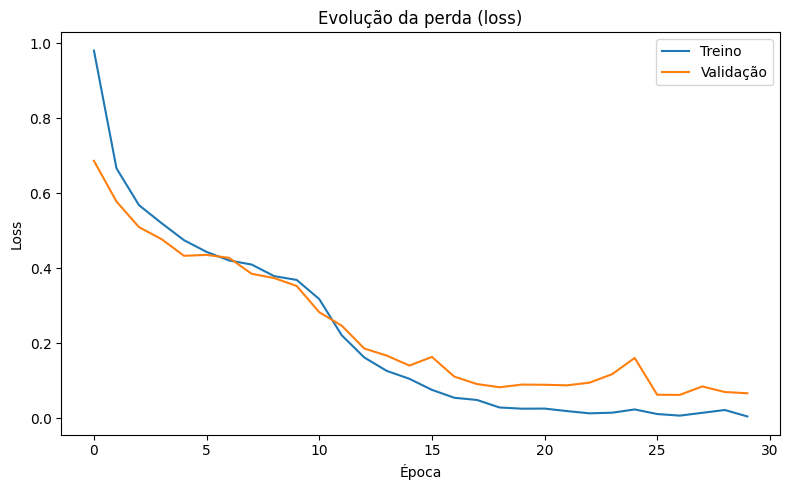

In [ ]:
loss = history.history['loss'] + history_finetune.history['loss'] + history_more_ft.history['loss']
val_loss = history.history['val_loss'] + history_finetune.history['val_loss'] + history_more_ft.history['val_loss']

plt.figure(figsize=(8, 5))
plt.plot(loss, label='Treino')
plt.plot(val_loss, label='Validação')
plt.title('Evolução da perda (loss)')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

test_loss, test_accuracy = model.evaluate(val_ds)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

40/40 ━━━━━━━━━━━━━━━━━━━━ 28s 703ms/step - accuracy: 0.9664 - loss: 0.0964
Test accuracy: 96.09%
48/48 ━━━━━━━━━━━━━━━━━━━━ 32s 676ms/step - accuracy: 0.9795 - loss: 0.0503
Test accuracy: 97.98%


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# 1. Descongelar TODAS as camadas da VGG16
for layer in base_model.layers:
    layer.trainable = True

# 2. Compilar novamente com learning rate muito baixo
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 3. Definir callback de EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# 4. Treinar mais 5 a 10 épocas
history_full_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    initial_epoch=30,   # Continuação correta
    epochs=40,          # até 40, ou o que quiseres
    callbacks=[early_stop]
)

Epoch 31/40
272/272 ━━━━━━━━━━━━━━━━━━━━ 804s 3s/step - accuracy: 0.9997 - loss: 0.0037 - val_accuracy: 0.9850 - val_loss: 0.0529
Epoch 32/40
272/272 ━━━━━━━━━━━━━━━━━━━━ 799s 3s/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9844 - val_loss: 0.0550
Epoch 33/40
272/272 ━━━━━━━━━━━━━━━━━━━━ 794s 3s/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.9844 - val_loss: 0.0505
Epoch 34/40
272/272 ━━━━━━━━━━━━━━━━━━━━ 798s 3s/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9811 - val_loss: 0.0702
Epoch 35/40
272/272 ━━━━━━━━━━━━━━━━━━━━ 794s 3s/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.9883 - val_loss: 0.0511
Epoch 36/40
272/272 ━━━━━━━━━━━━━━━━━━━━ 792s 3s/step - accuracy: 1.0000 - loss: 8.1556e-04 - val_accuracy: 0.9876 - val_loss: 0.0459
Epoch 37/40
272/272 ━━━━━━━━━━━━━━━━━━━━ 792s 3s/step - accuracy: 1.0000 - loss: 6.3710e-04 - val_accuracy: 0.9883 - val_loss: 0.0508
Epoch 38/40
272/272 ━━━━━━━━━━━━━━━━━━━━ 793s 3s/step - accuracy: 1.0000 - loss: 5

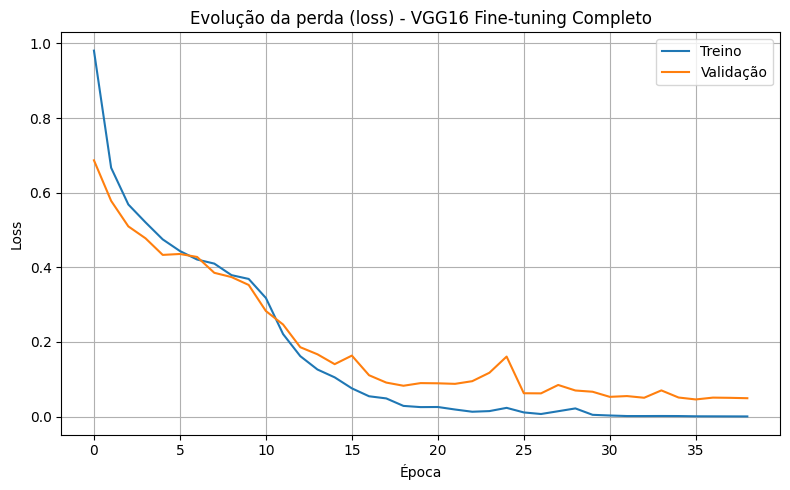

In [ ]:
import matplotlib.pyplot as plt

# Combinar todos os loss
loss = (
    history.history['loss'] + 
    history_finetune.history['loss'] + 
    history_more_ft.history['loss'] + 
    history_full_finetune.history['loss']
)
val_loss = (
    history.history['val_loss'] + 
    history_finetune.history['val_loss'] + 
    history_more_ft.history['val_loss'] + 
    history_full_finetune.history['val_loss']
)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(loss, label='Treino')
plt.plot(val_loss, label='Validação')
plt.title('Evolução da perda (loss) - VGG16 Fine-tuning Completo')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"\n✅ Test Accuracy (VGG16 - Fine-tuning Total): {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


40/40 ━━━━━━━━━━━━━━━━━━━━ 28s 709ms/step - accuracy: 0.9778 - loss: 0.0701

✅ Test Accuracy (VGG16 - Fine-tuning Total): 97.42%
Test Loss: 0.0692


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 944ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 821ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 810ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2025-05-11 20:56:08.131747: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


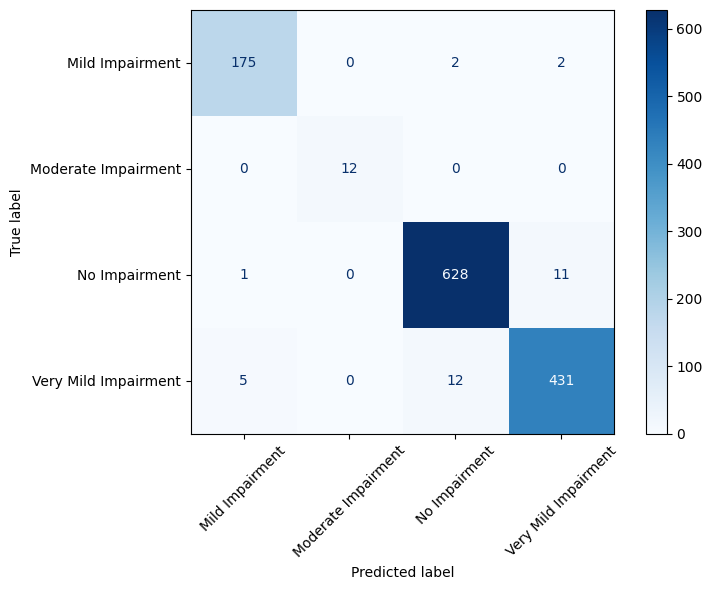

                      precision    recall  f1-score   support

     Mild Impairment       0.97      0.98      0.97       179
 Moderate Impairment       1.00      1.00      1.00        12
       No Impairment       0.98      0.98      0.98       640
Very Mild Impairment       0.97      0.96      0.97       448

            accuracy                           0.97      1279
           macro avg       0.98      0.98      0.98      1279
        weighted avg       0.97      0.97      0.97      1279



In [ ]:
y_true, y_pred = [], []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(8, 6))  
disp.plot(cmap='Blues', ax=ax)
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
model.save("modelo_vgg16_final_96percent.h5")

In [ ]:
plt.savefig("grafico_loss_vgg16_finetuning.png", dpi=300)


<Figure size 640x480 with 0 Axes>

In [ ]:

# Load the model from file
model = load_model("modelo_vgg16_final_96percent.h5")
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"✅ Accuracy: {test_accuracy * 100:.2f}%")
print(f"Loss: {test_loss:.4f}")
